In [1]:
source('../load_environment.R')

Pivot Bio, Inc.
This code performs analyses supporting findings of the paper entitled:
"Genetic remodeling of soil diazotrophs enables partial replacement of synthetic nitrogen fertilizer with biological nitrogen fixation in maize".

##------ Thu Jun 06 10:02:24 2024 ------## 
Loaded packages:  tidyverse, readxl, broom, foreach, nlme, lme4, lmerTest, glmmTMB, car, DHARMa, caret, emmeans, multcomp, ggpubr, scales, png, ggthemes and their dependencies.
A complete list of packages used in the analysis is provided in the `packages_citations.txt` file.


In [2]:
# Global variables
set.seed(100) # For repoducibility 
alpha_level <- 0.05 # For test of hypothesis and confidence levels
n_boot_sims <- 300 # Number of simulations for bootstrapping
use_cached_boostrapping <- TRUE # whether to use cached data for boostrapping

# For plotting
#theme_set(theme_base() + theme(plot.background = element_blank(), axis.ticks.length = unit(1.5,"mm")))
#myColorPalette <- c("#005AB5","#DC3220")

## Dataset 

In [3]:
df <- 
read_csv("./datasets/yield_response_purdue.csv") %>% 
mutate(Year = factor(Year), Rep = factor(Rep), 
       grp = Year:Rep, #site within rep,
       N_Rate_num = N_rate_lbac*1.12, # to kg/ha
       yield = yield_buac*0.06277, # to Mg /ha
       Microbe = factor(Microbe,levels = c("UTC","PROVEN40")))

Rows: 192 Columns: 5
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (1): Microbe
dbl (4): Year, Rep, N_rate_lbac, yield_buac

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
str(df)

tibble [192 x 8] (S3: tbl_df/tbl/data.frame)
 $ Year       : Factor w/ 2 levels "2021","2022": 1 1 1 1 1 1 1 1 1 1 ...
 $ Rep        : Factor w/ 8 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ N_rate_lbac: num [1:192] 0 0 95 95 175 175 215 215 255 255 ...
 $ Microbe    : Factor w/ 2 levels "UTC","PROVEN40": 2 1 2 1 2 1 2 1 2 1 ...
 $ yield_buac : num [1:192] 134 119 227 218 243 ...
 $ grp        : Factor w/ 16 levels "2021:1","2021:2",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ N_Rate_num : num [1:192] 0 0 106 106 196 ...
 $ yield      : num [1:192] 8.42 7.49 14.27 13.67 15.26 ...


In [5]:
df %>%
 group_by(Year) %>%
 summarize(mean_yield_kg_ha_15.5 = mean(yield), sd_yield_kg_ha_15.5 = sd(yield) )

Year,mean_yield_kg_ha_15.5,sd_yield_kg_ha_15.5
<fct>,<dbl>,<dbl>
2021,14.88982,3.478812
2022,13.28977,2.840111


In [6]:
df %>%
 group_by(Microbe) %>%
 summarize(mean_yield_kg_ha_15.5 = mean(yield), sd_yield_kg_ha_15.5 = sd(yield) )

Microbe,mean_yield_kg_ha_15.5,sd_yield_kg_ha_15.5
<fct>,<dbl>,<dbl>
UTC,13.90932,3.354501
PROVEN40,14.27026,3.184872


In [7]:
14.27707 - 13.91596

[1] 0.36111

In [8]:
t.test(yield ~ Microbe, data = df)


	Welch Two Sample t-test

data:  yield by Microbe
t = -0.76455, df = 189.49, p-value = 0.4455
alternative hypothesis: true difference in means between group UTC and group PROVEN40 is not equal to 0
95 percent confidence interval:
 -1.2921820  0.5703008
sample estimates:
     mean in group UTC mean in group PROVEN40 
              13.90932               14.27026 


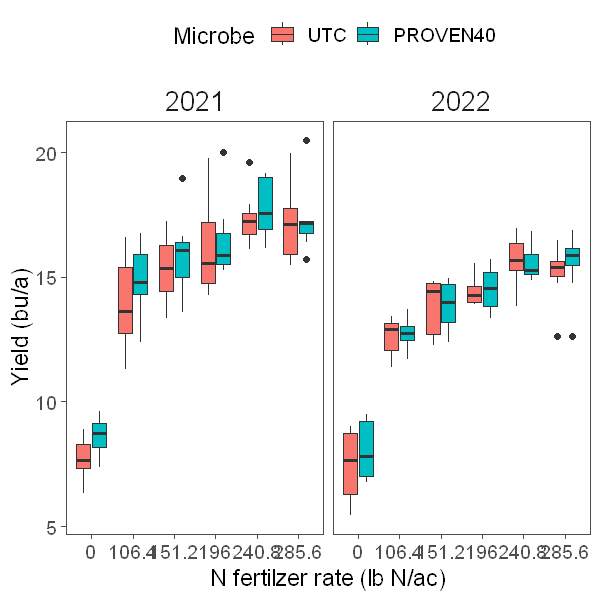

In [9]:
# Quick look at the data (all data)

df %>% 
ggplot(aes(factor(N_Rate_num),yield,fill = Microbe)) + 
geom_boxplot() + 
facet_grid(~Year) + 
theme(legend.position = "top") +
labs(y = "Yield (bu/a)", x = "N fertilzer rate (lb N/ac)")

## Definition of the non-linear model

A general model for yield response to fertilizer is given by a quadratic plateau equation:

$$Y(N_f) = (a + bN_{f} + cN_{f}^2) * (N_{f} <= -0.5 \frac{b}{c}) + (a + \frac{-b^2}{4c}) * (N_{f} > -0.5  \frac{b}{c})$$

where:
  - `Nf` is the nitrogen fertilizer rate
  - `Y(Nf)` is the yield as function  Nf 
  - `a` is the yield with no N fertilizer
  - `b` is the slope of the respons at Nf = 0
  - `c` is the diminishing return parameter
  
Further, `c` can be re-written in terms of the water-limited yield potential (`ymax`):

$$c = \frac{-b^2}{ 4 (Y_{max}-a)}$$

Therefore, our model would be:


$$Y(N_f) = (a + bN_{f} + \frac{-b^2}{ 4 (Y_{max}-a)} N_{f}^2) * (N_{f} <= \frac{-2(Y_{max}-a)}{b}) + Y_{max}*(N_{f} > \frac{-2(Y_{max}-a)}{b})$$



In [10]:
# Define model equation

yield_nresp <- function(Nf,
                        a,
                        b,
                        ymax){
    
    # Calulate c for simplicity 
    c = (-b**2)/(4*(ymax-a))
    
    # Standard QP equation
    y = (a + b * Nf + c * (Nf**2)) * (Nf <= -0.5 * b/c) + (a + (-b**2/(4 * c))) * (Nf > -0.5 * b/c)
    
    return(y)
}

## Non-linear fit with `nls` to obtain benchmark values 

In [11]:
# some starting values 
start_coefs <- c(coef(lm(yield~N_Rate_num, data = df)),mean(df$yield[df$N_Rate_num == max(df$N_Rate_num)]))
start_coefs

(Intercept)  N_Rate_num             
 9.30249863  0.02930996 16.26200044

In [12]:
fit.nls <- nls(yield ~ yield_nresp(N_Rate_num, a, b, ymax),
               start = list(a = start_coefs[1], b = start_coefs[2]*2, ymax = start_coefs[3]),
               data = df)

summary(fit.nls)


Formula: yield ~ yield_nresp(N_Rate_num, a, b, ymax)

Parameters:
     Estimate Std. Error t value Pr(>|t|)    
a     8.01534    0.25837   31.02   <2e-16 ***
b     0.06243    0.00405   15.41   <2e-16 ***
ymax 16.35943    0.21168   77.28   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.485 on 189 degrees of freedom

Number of iterations to convergence: 5 
Achieved convergence tolerance: 1.095e-06


In [13]:
# Extract coefficiencts for better starting values 
start_coefs <- coefficients(fit.nls)

## Non-linear mixed effect model using `nlme`

In [14]:
fit.nlme.null <- nlme(yield ~ yield_nresp(N_Rate_num, a, b, ymax),
            data = df,
            fixed = a + b + ymax ~ 1, # No fixed effects on parameters
            random = list(Year = pdDiag(a + b + ymax ~ 1),  # Random effect of Year
                          Rep = pdDiag(a + b + ymax~ 1)),   # Random effect of Rep
            start = start_coefs)

In [15]:
summary(fit.nlme.null)

Nonlinear mixed-effects model fit by maximum likelihood
  Model: yield ~ yield_nresp(N_Rate_num, a, b, ymax) 
  Data: df 
       AIC      BIC    logLik
  576.4848 609.0597 -278.2424

Random effects:
 Formula: list(a ~ 1, b ~ 1, ymax ~ 1)
 Level: Year
 Structure: Diagonal
                   a           b      ymax
StdDev: 0.0001329234 0.008565446 0.8641589

 Formula: list(a ~ 1, b ~ 1, ymax ~ 1)
 Level: Rep %in% Year
 Structure: Diagonal
                a          b     ymax  Residual
StdDev: 0.7122239 0.01144035 1.064867 0.8437366

Fixed effects:  a + b + ymax ~ 1 
         Value Std.Error  DF  t-value p-value
a     8.001715 0.2323610 174 34.43657       0
b     0.063521 0.0071656 174  8.86474       0
ymax 16.497214 0.6880803 174 23.97571       0
 Correlation: 
     a      b     
b    -0.148       
ymax  0.016 -0.032

Standardized Within-Group Residuals:
         Min           Q1          Med           Q3          Max 
-2.138216258 -0.600043874 -0.004107165  0.634533339  2.668612139 

N

In [16]:
# Let's compare improvement in model fit
AIC(fit.nls)
AIC(fit.nlme.null)

[1] 701.6078

[1] 576.4848

### Full Model

Let's beging with a `full` model that includes the interactive effects of `Microbe` and `Year` on all three parameters

In [17]:
fit.nlme.full <- update(fit.nlme.null,
       fixed = list(a + b + ymax ~ Microbe*Year),# Interaction affects all parameters 
       start = c(start_coefs["a"],0,0,0, # effects on a
                 start_coefs["b"],0,0,0, # effects on b
                 start_coefs["ymax"],0,0,0 # effects on ymax
                ))

#### Check model assumptions

Diagnostic plot to check the residuals

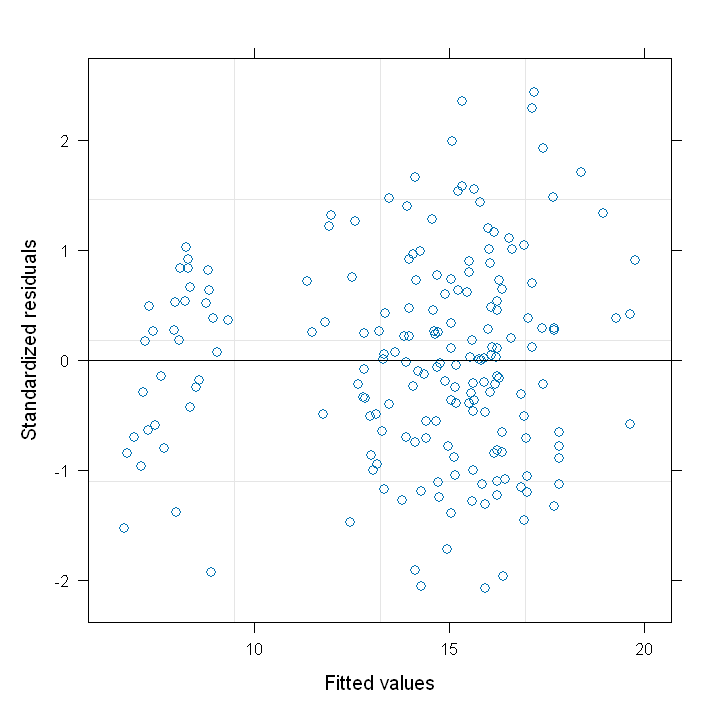

In [18]:
options(repr.plot.width=6, repr.plot.height=6)
plot(fit.nlme.full)

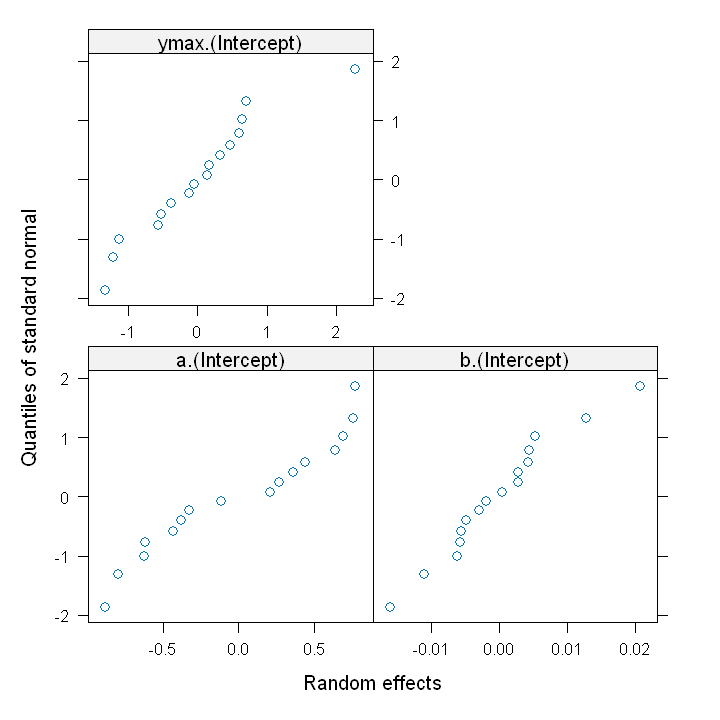

In [19]:
qqnorm(fit.nlme.full, ~ranef(., level=2))

Check for equal variances between groups:

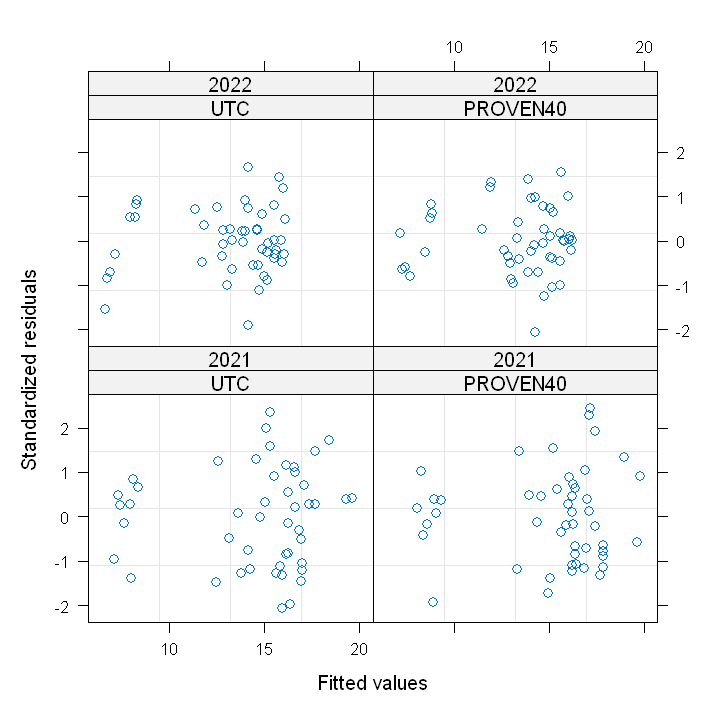

In [20]:
plot(fit.nlme.full, resid(., type = "p") ~ fitted(.) | Microbe*Year)

#### Inspect random effects

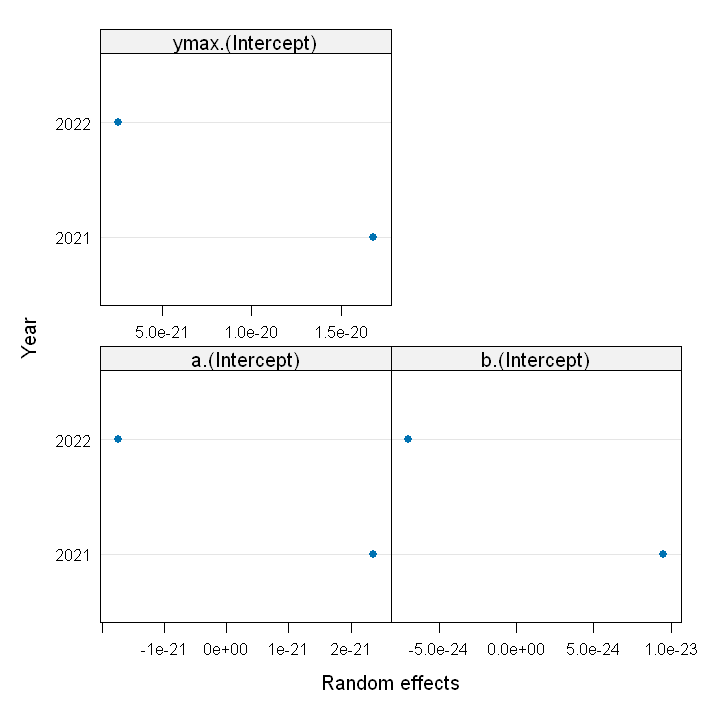

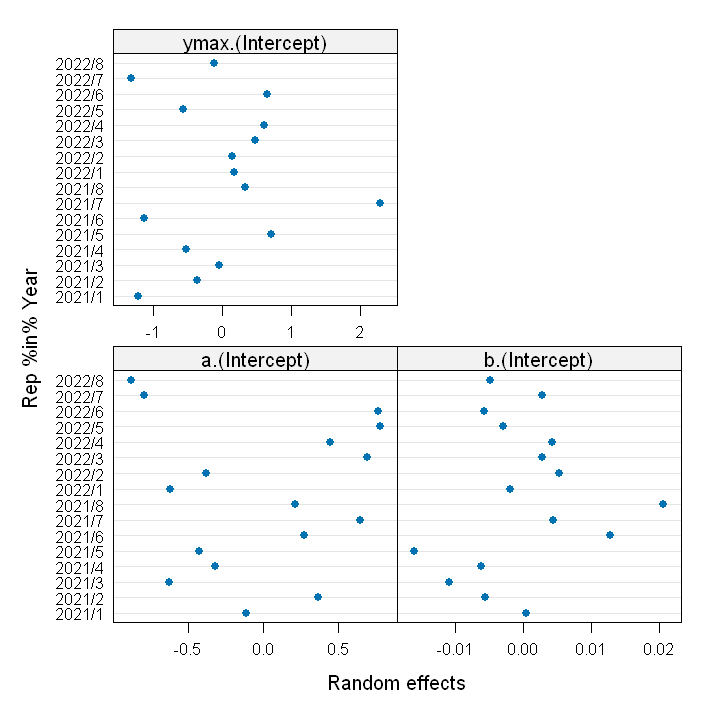

In [21]:
plot(random.effects(fit.nlme.full,level = 1))
plot(random.effects(fit.nlme.full,level = 2))

#### Inspect fixed effects 

In [22]:
summary(fit.nlme.full)

Nonlinear mixed-effects model fit by maximum likelihood
  Model: yield ~ yield_nresp(N_Rate_num, a, b, ymax) 
  Data: df 
       AIC      BIC    logLik
  567.6248 629.5172 -264.8124

Random effects:
 Formula: list(a ~ 1, b ~ 1, ymax ~ 1)
 Level: Year
 Structure: Diagonal
        a.(Intercept) b.(Intercept) ymax.(Intercept)
StdDev:  3.384601e-05  5.727546e-07     5.283298e-05

 Formula: list(a ~ 1, b ~ 1, ymax ~ 1)
 Level: Rep %in% Year
 Structure: Diagonal
        a.(Intercept) b.(Intercept) ymax.(Intercept)  Residual
StdDev:      0.695469    0.01069756        0.9854007 0.7990807

Fixed effects:  list(a + b + ymax ~ Microbe * Year) 
                                  Value Std.Error  DF  t-value p-value
a.(Intercept)                  7.721251 0.3805663 165 20.28884  0.0000
a.MicrobePROVEN40              0.962188 0.3988476 165  2.41242  0.0169
a.Year2022                    -0.194570 0.5393325 165 -0.36076  0.7187
a.MicrobePROVEN40:Year2022    -0.426112 0.5657414 165 -0.75319  0.4524
b.(I

In [23]:
fit.nlme.full.summary <- summary(fit.nlme.full)
fit.nlme.full.summary$tTable

,Value,Std.Error,DF,t-value,p-value
a.(Intercept),7.7212510160,0.380566348,165,20.28884333,1.078093e-46
a.MicrobePROVEN40,0.9621876589,0.398847641,165,2.41241908,1.694341e-02
a.Year2022,-0.1945704063,0.539332472,165,-0.36076153,7.187392e-01
a.MicrobePROVEN40:Year2022,-0.4261122582,0.565741388,165,-0.75319266,4.524075e-01
b.(Intercept),0.0724040784,0.005831056,165,12.41697562,2.028342e-25
b.MicrobePROVEN40,-0.0001740825,0.005755115,165,-0.03024832,9.759056e-01
b.Year2022,-0.0149836081,0.008248942,165,-1.81642783,7.111969e-02
b.MicrobePROVEN40:Year2022,-0.0047513170,0.008172099,165,-0.58140714,5.617595e-01
ymax.(Intercept),17.3736961289,0.444485728,165,39.08718557,2.493546e-85
ymax.MicrobePROVEN40,0.1301732913,0.310051499,165,0.41984410,6.751455e-01


Of interest to us is to check how the treatments affected each parameter. The visualization below shows estimated effect sizes with confidence intervals.

,lower,est.,upper,param,term,Value,Std.Error,DF,t.value,p.value
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a.(Intercept),6.99370377,7.7212510160,8.4487982607,a,(Intercept),7.7212510160,0.380566348,165,20.28884333,1.078093e-46
a.MicrobePROVEN40,0.19969118,0.9621876589,1.7246841422,a,MicrobePROVEN40,0.9621876589,0.398847641,165,2.41241908,1.694341e-02
a.Year2022,-1.22563859,-0.1945704063,0.8364977794,a,Year2022,-0.1945704063,0.539332472,165,-0.36076153,7.187392e-01
a.MicrobePROVEN40:Year2022,-1.50766766,-0.4261122582,0.6554431396,a,MicrobePROVEN40:Year2022,-0.4261122582,0.565741388,165,-0.75319266,4.524075e-01
b.(Intercept),0.06125656,0.0724040784,0.0835515922,b,(Intercept),0.0724040784,0.005831056,165,12.41697562,2.028342e-25
b.MicrobePROVEN40,-0.01117642,-0.0001740825,0.0108282524,b,MicrobePROVEN40,-0.0001740825,0.005755115,165,-0.03024832,9.759056e-01
b.Year2022,-0.03075351,-0.0149836081,0.0007862968,b,Year2022,-0.0149836081,0.008248942,165,-1.81642783,7.111969e-02
b.MicrobePROVEN40:Year2022,-0.02037432,-0.0047513170,0.0108716840,b,MicrobePROVEN40:Year2022,-0.0047513170,0.008172099,165,-0.58140714,5.617595e-01
ymax.(Intercept),16.52395109,17.3736961289,18.2234411684,ymax,(Intercept),17.3736961289,0.444485728,165,39.08718557,2.493546e-85


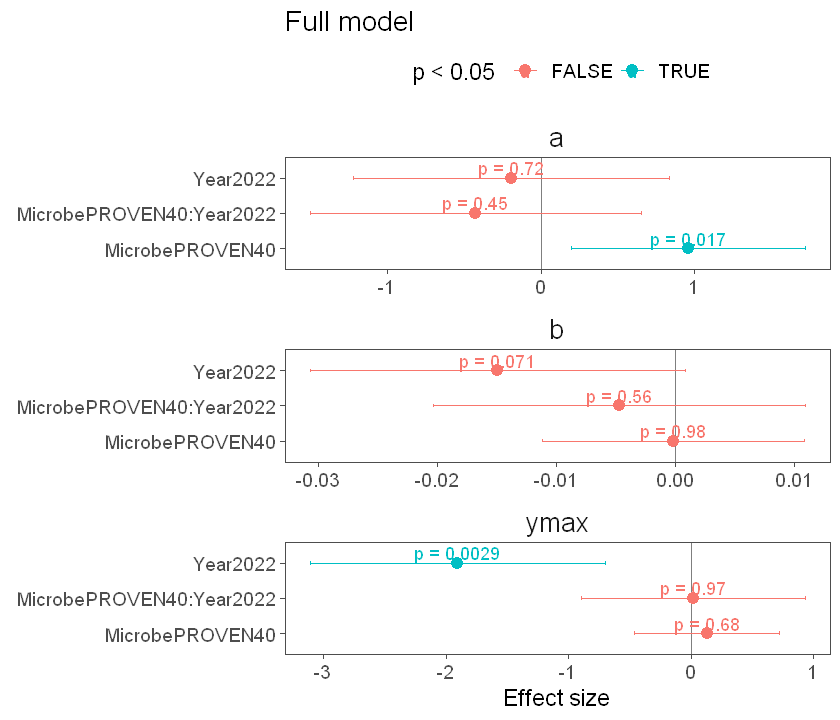

In [24]:
options(repr.plot.width=7, repr.plot.height=6)


fit.nlme.full_effects <- 
intervals(fit.nlme.full,level = 1 - alpha_level,which = "fixed")$fixed %>% 
as.data.frame() %>% 
mutate(term = row.names(.)) %>% 
bind_cols(fit.nlme.full.summary$tTable %>% data.frame()) %>% 
separate(term, c("param","term"), sep = "\\.") 

fit.nlme.full_effects

fit.nlme.full_effects %>% 
filter(!grepl("Int",term))   %>%
ggplot(aes(est., term, colour = p.value < alpha_level)) +
geom_vline(xintercept = 0, colour = "gray50") + 
geom_errorbarh(aes(xmin = lower, xmax = upper), height = 0.1) + 
geom_point(size = 3) +
geom_text(aes(label = paste0("p = ", signif(p.value,2))),nudge_y = 0.3) + 
facet_wrap(~param,ncol = 1, scales = "free") + 
labs(y = "", x = "Effect size", title = "Full model", colour = paste0("p < ",alpha_level)) + 
theme(legend.position = "top")

Overall reading of these results:

- Strong evidence that `ymax` was higher in 2021 overall
- Convicing evidence that `Microbe` increased `a` across both years
- Little or no evidence that `Microbe` affected `ymax` or `b` in either year 
- Little or no evidence that `Year` affected `b` in either of the `Microbe` treatments


## Model selection 

The full model seems to be overpameterized, so we might want to test simpler models that can help us see the effects more clearly. For this we pogresively reduce the model complexity...

In [25]:
### Interactive effects on a, and both main effects on b and ymax
fit.nlme.red1 <- update(fit.nlme.null,
       fixed = list(a ~ Microbe*Year, b + ymax ~ Microbe + Year),
       start = c(start_coefs["a"],0,0,0,
                 start_coefs["b"],0,0,
                 start_coefs["ymax"],0,0))

In [26]:
### Only main effects on all parameters
fit.nlme.red2 <- update(fit.nlme.null,
       fixed = list(a + b + ymax ~ Microbe + Year),
       start = c(start_coefs["a"],0,0,
                 start_coefs["b"],0,0,
                 start_coefs["ymax"],0,0))

In [27]:
### Interactive effects on a, and only year effects on b and ymax
fit.nlme.red3 <- update(fit.nlme.null,
       fixed = list(a ~ Microbe*Year, b + ymax ~ Year),
       start = c(start_coefs["a"],0,0,0,
                 start_coefs["b"],0,
                 start_coefs["ymax"],0))

In [28]:
### Main effects on a, and main effect of Year on b and ymax
fit.nlme.red4 <- update(fit.nlme.null,
       fixed = list(a ~ Microbe + Year, b + ymax ~ Year),
       start = c(start_coefs["a"],0,0,
                 start_coefs["b"],0,
                 start_coefs["ymax"],0))

In [29]:
### Main effects on a, and main effect of Year on b and ymax
fit.nlme.red5 <- update(fit.nlme.null,
       fixed = list(a ~ Microbe, b + ymax ~ Year),
       start = c(start_coefs["a"],0,
                 start_coefs["b"],0,
                 start_coefs["ymax"],0))

In [30]:
### Only year main effects
fit.nlme.red6 <- update(fit.nlme.null,
       fixed = list(a + b + ymax ~ Year),
       start = c(start_coefs["a"],0,
                 start_coefs["b"],0,
                 start_coefs["ymax"],0))

,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
fit.nlme.full,"nlme.formula(model = yield ~ yield_nresp(N_Rate_num, a, b, ymax), data = df, fixed = list(a + b + ymax ~ Microbe * Year), random = list(Year = pdDiag(a + b + ymax ~ 1), Rep = pdDiag(a + b + ymax ~ 1)), start = c(start_coefs[""a""], 0, 0, 0, start_coefs[""b""], 0, 0, 0, start_coefs[""ymax""], 0, 0, 0))",1,19,567.6248,629.5172,-264.8124,,NA,NA
fit.nlme.red1,"nlme.formula(model = yield ~ yield_nresp(N_Rate_num, a, b, ymax), data = df, fixed = list(a ~ Microbe * Year, b + ymax ~ Microbe + Year), random = list(Year = pdDiag(a + b + ymax ~ 1), Rep = pdDiag(a + b + ymax ~ 1)), start = c(start_coefs[""a""], 0, 0, 0, start_coefs[""b""], 0, 0, start_coefs[""ymax""], 0, 0))",2,17,563.9059,619.2834,-264.9530,1 vs 2,0.2811073,0.86887704
fit.nlme.red2,"nlme.formula(model = yield ~ yield_nresp(N_Rate_num, a, b, ymax), data = df, fixed = list(a + b + ymax ~ Microbe + Year), random = list(Year = pdDiag(a + b + ymax ~ 1), Rep = pdDiag(a + b + ymax ~ 1)), start = c(start_coefs[""a""], 0, 0, start_coefs[""b""], 0, 0, start_coefs[""ymax""], 0, 0))",3,16,565.5758,617.6958,-266.7879,2 vs 3,3.6698854,0.05540399
fit.nlme.red3,"nlme.formula(model = yield ~ yield_nresp(N_Rate_num, a, b, ymax), data = df, fixed = list(a ~ Microbe * Year, b + ymax ~ Year), random = list(Year = pdDiag(a + b + ymax ~ 1), Rep = pdDiag(a + b + ymax ~ 1)), start = c(start_coefs[""a""], 0, 0, 0, start_coefs[""b""], 0, start_coefs[""ymax""], 0))",4,15,560.6401,609.5026,-265.3201,3 vs 4,2.9356800,0.08664217
fit.nlme.red4,"nlme.formula(model = yield ~ yield_nresp(N_Rate_num, a, b, ymax), data = df, fixed = list(a ~ Microbe + Year, b + ymax ~ Year), random = list(Year = pdDiag(a + b + ymax ~ 1), Rep = pdDiag(a + b + ymax ~ 1)), start = c(start_coefs[""a""], 0, 0, start_coefs[""b""], 0, start_coefs[""ymax""], 0))",5,14,562.4241,608.0290,-267.2120,4 vs 5,3.7839134,0.05174750
fit.nlme.red5,"nlme.formula(model = yield ~ yield_nresp(N_Rate_num, a, b, ymax), data = df, fixed = list(a ~ Microbe, b + ymax ~ Year), random = list(Year = pdDiag(a + b + ymax ~ 1), Rep = pdDiag(a + b + ymax ~ 1)), start = c(start_coefs[""a""], 0, start_coefs[""b""], 0, start_coefs[""ymax""], 0))",6,13,561.3007,603.6482,-267.6504,5 vs 6,0.8766696,0.34911548
fit.nlme.red6,"nlme.formula(model = yield ~ yield_nresp(N_Rate_num, a, b, ymax), data = df, fixed = list(a + b + ymax ~ Year), random = list(Year = pdDiag(a + b + ymax ~ 1), Rep = pdDiag(a + b + ymax ~ 1)), start = c(start_coefs[""a""], 0, start_coefs[""b""], 0, start_coefs[""ymax""], 0))",7,13,571.6845,614.0320,-272.8423,,NA,NA
fit.nlme.null,"nlme.formula(model = yield ~ yield_nresp(N_Rate_num, a, b, ymax), data = df, fixed = a + b + ymax ~ 1, random = list(Year = pdDiag(a + b + ymax ~ 1), Rep = pdDiag(a + b + ymax ~ 1)), start = start_coefs)",8,10,576.4848,609.0597,-278.2424,7 vs 8,10.8002640,0.01285644


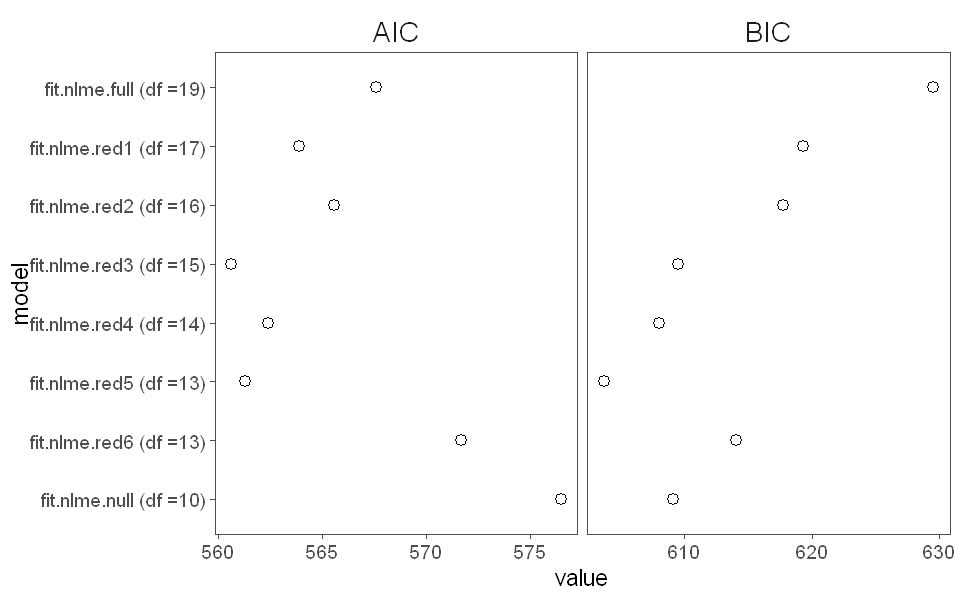

In [31]:
model_comparion_table <- anova(
    fit.nlme.full,
    fit.nlme.red1,
    fit.nlme.red2,
    fit.nlme.red3,
    fit.nlme.red4,
    fit.nlme.red5,
    fit.nlme.red6,
    fit.nlme.null)

options(repr.plot.width=8, repr.plot.height=5)

model_comparion_table

as.data.frame(model_comparion_table) %>%
transmute(model = paste0(row.names(.)," (df =",df,")"),
          model = factor(model,levels = rev(model)),
          df,AIC,BIC) %>% 
gather(index,value,AIC,BIC) %>% 
group_by(index) %>% 
mutate(best = value == min(value))  %>%
ggplot(aes(value,model)) + 
geom_point(size = 3, shape = 21) + 
facet_grid(~index,scales = "free")

Based solely on the `AIC` we would choose `fit.nlme.red3`, but the `BIC` indicates that `fit.nlme.red4` and `fit.nlme.red5` are better model because they are more parsimonious with a similar model fit. However, there is a hit that `fit.nlme.red3` constains potentially significant effects that are not accounted by the more parsimonious models, namely that the microbial effect on `a` depends on year.  

In [32]:
anova(fit.nlme.red3,fit.nlme.red4)[-1]
anova(fit.nlme.red3,fit.nlme.red5)[-1]
anova(fit.nlme.red4,fit.nlme.red5)[-1]

,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
fit.nlme.red3,1,15,560.6401,609.5026,-265.3201,,NA,NA
fit.nlme.red4,2,14,562.4241,608.0290,-267.2120,1 vs 2,3.783913,0.0517475


,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
fit.nlme.red3,1,15,560.6401,609.5026,-265.3201,,NA,NA
fit.nlme.red5,2,13,561.3007,603.6482,-267.6504,1 vs 2,4.660583,0.09726739


,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
fit.nlme.red4,1,14,562.4241,608.0290,-267.2120,,NA,NA
fit.nlme.red5,2,13,561.3007,603.6482,-267.6504,1 vs 2,0.8766696,0.3491155


Therefore, we choose `fit.nlme.red3` as the reduced model going forward. 

In [33]:
fit.nlme.red <- fit.nlme.red3

### Chosen Reduced model

#### Check model assumptions

Diagnostic plot to check the residuals

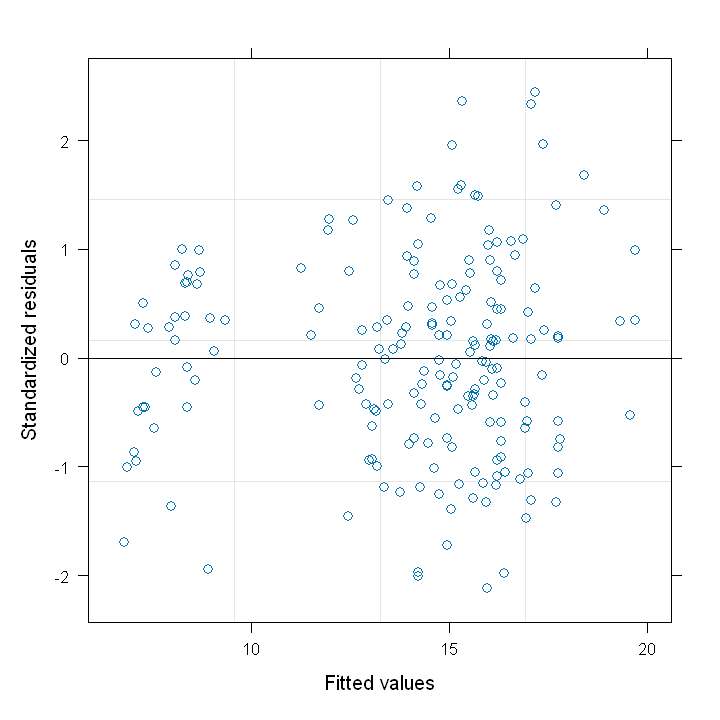

In [34]:
options(repr.plot.width=6, repr.plot.height=6)
plot(fit.nlme.red)

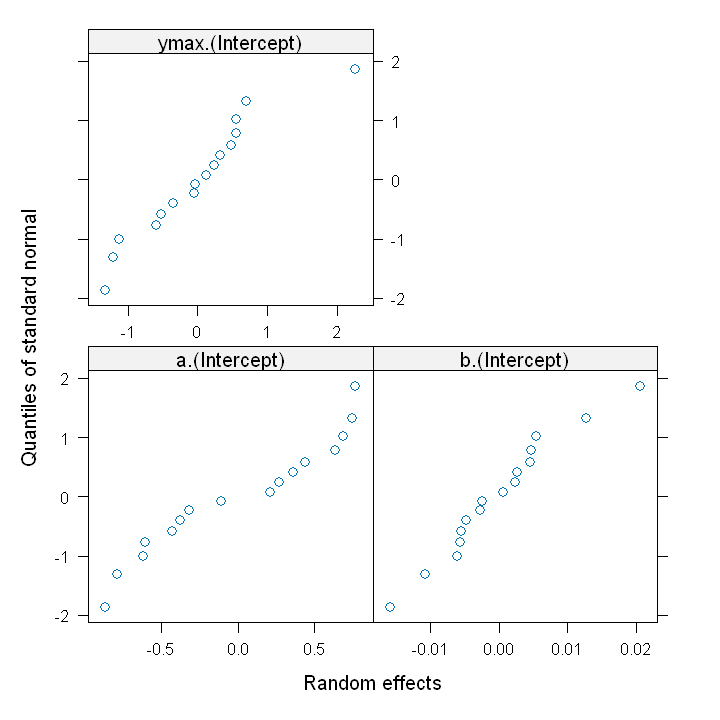

In [35]:
qqnorm(fit.nlme.red, ~ranef(., level=2))

Check for equal variances between groups:

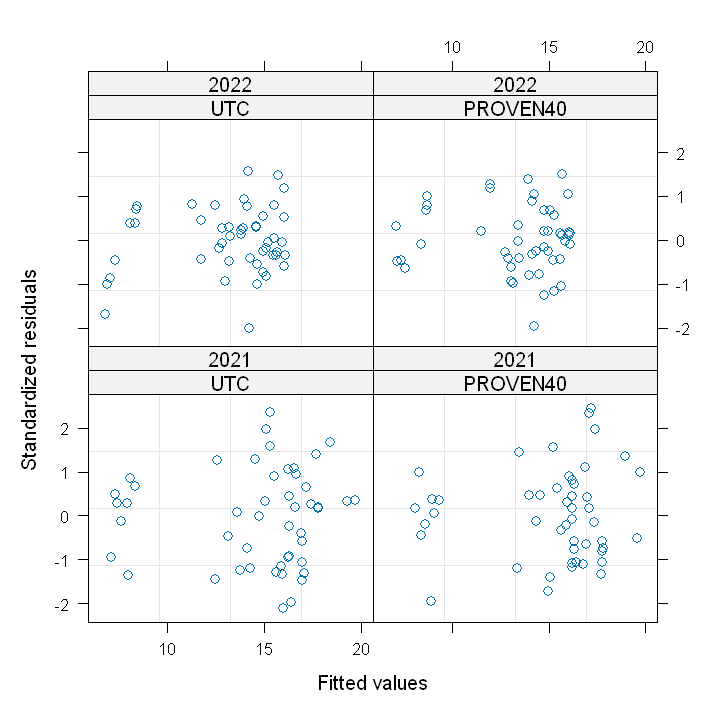

In [36]:
plot(fit.nlme.red, resid(., type = "p") ~ fitted(.) | Microbe*Year)

### Inspect Model

In [37]:
fit.nlme.red.summary <- summary(fit.nlme.red)
fit.nlme.red.summary

Nonlinear mixed-effects model fit by maximum likelihood
  Model: yield ~ yield_nresp(N_Rate_num, a, b, ymax) 
  Data: df 
       AIC      BIC    logLik
  560.6401 609.5026 -265.3201

Random effects:
 Formula: list(a ~ 1, b ~ 1, ymax ~ 1)
 Level: Year
 Structure: Diagonal
        a.(Intercept) b.(Intercept) ymax.(Intercept)
StdDev:  3.431565e-05  5.798935e-07     5.344663e-05

 Formula: list(a ~ 1, b ~ 1, ymax ~ 1)
 Level: Rep %in% Year
 Structure: Diagonal
        a.(Intercept) b.(Intercept) ymax.(Intercept)  Residual
StdDev:     0.6902541    0.01065945         0.980828 0.8024261

Fixed effects:  list(a ~ Microbe * Year, b + ymax ~ Year) 
                               Value Std.Error  DF  t-value p-value
a.(Intercept)               7.710065 0.3494249 169 22.06502  0.0000
a.MicrobePROVEN40           0.989536 0.2671675 169  3.70381  0.0003
a.Year2022                 -0.059107 0.4914266 169 -0.12028  0.9044
a.MicrobePROVEN40:Year2022 -0.700111 0.3687965 169 -1.89837  0.0594
b.(Intercept)

### Inspect random effects

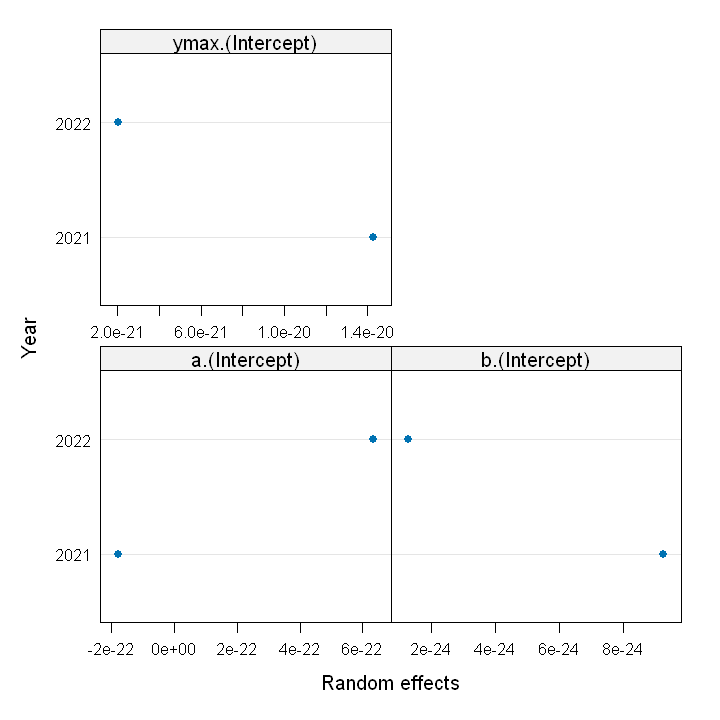

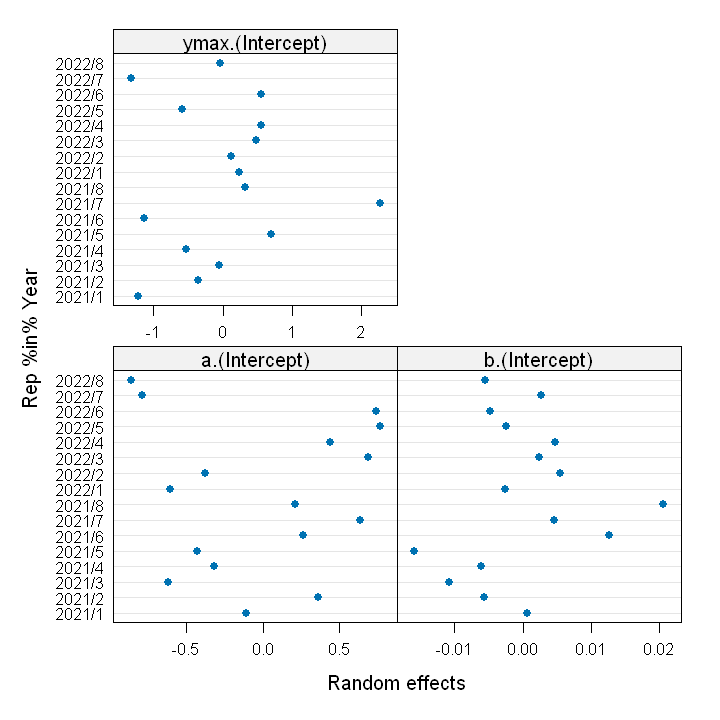

In [38]:
plot(random.effects(fit.nlme.red,level = 1))
plot(random.effects(fit.nlme.red,level = 2))

In [39]:
fit.nlme.red.summary

Nonlinear mixed-effects model fit by maximum likelihood
  Model: yield ~ yield_nresp(N_Rate_num, a, b, ymax) 
  Data: df 
       AIC      BIC    logLik
  560.6401 609.5026 -265.3201

Random effects:
 Formula: list(a ~ 1, b ~ 1, ymax ~ 1)
 Level: Year
 Structure: Diagonal
        a.(Intercept) b.(Intercept) ymax.(Intercept)
StdDev:  3.431565e-05  5.798935e-07     5.344663e-05

 Formula: list(a ~ 1, b ~ 1, ymax ~ 1)
 Level: Rep %in% Year
 Structure: Diagonal
        a.(Intercept) b.(Intercept) ymax.(Intercept)  Residual
StdDev:     0.6902541    0.01065945         0.980828 0.8024261

Fixed effects:  list(a ~ Microbe * Year, b + ymax ~ Year) 
                               Value Std.Error  DF  t-value p-value
a.(Intercept)               7.710065 0.3494249 169 22.06502  0.0000
a.MicrobePROVEN40           0.989536 0.2671675 169  3.70381  0.0003
a.Year2022                 -0.059107 0.4914266 169 -0.12028  0.9044
a.MicrobePROVEN40:Year2022 -0.700111 0.3687965 169 -1.89837  0.0594
b.(Intercept)

#### Inspect fixed effects 

In [40]:
fit.nlme.red.summary <- summary(fit.nlme.red)
fit.nlme.red.summary$tTable

,Value,Std.Error,DF,t-value,p-value
a.(Intercept),7.71006531,0.349424879,169,22.0650154,1.221210e-51
a.MicrobePROVEN40,0.98953621,0.267167462,169,3.7038051,2.873508e-04
a.Year2022,-0.05910676,0.491426631,169,-0.1202759,9.044075e-01
a.MicrobePROVEN40:Year2022,-0.70011121,0.368796541,169,-1.8983671,5.935217e-02
b.(Intercept),0.07216871,0.005148300,169,14.0179671,4.093157e-30
b.Year2022,-0.01718468,0.007135337,169,-2.4083910,1.709856e-02
ymax.(Intercept),17.44761100,0.402852430,169,43.3101794,2.054935e-93
ymax.Year2022,-1.89986284,0.574401893,169,-3.3075498,1.149860e-03


Of interest to us is to check how the treatments affected each parameter. The visualization below shows estimated effect sizes with confidence intervals.

,lower,est.,upper,param,term,Value,Std.Error,DF,t.value,p.value
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a.MicrobePROVEN40,0.47322553,0.98953621,1.505846890,a,MicrobePROVEN40,0.98953621,0.267167462,169,3.7038051,0.0002873508
a.Year2022,-1.00880631,-0.05910676,0.890592788,a,Year2022,-0.05910676,0.491426631,169,-0.1202759,0.9044074955
a.MicrobePROVEN40:Year2022,-1.41282372,-0.70011121,0.012601302,a,MicrobePROVEN40:Year2022,-0.70011121,0.368796541,169,-1.8983671,0.0593521719
b.Year2022,-0.03097398,-0.01718468,-0.003395388,b,Year2022,-0.01718468,0.007135337,169,-2.4083910,0.0170985603
ymax.Year2022,-3.00991506,-1.89986284,-0.789810630,ymax,Year2022,-1.89986284,0.574401893,169,-3.3075498,0.0011498605


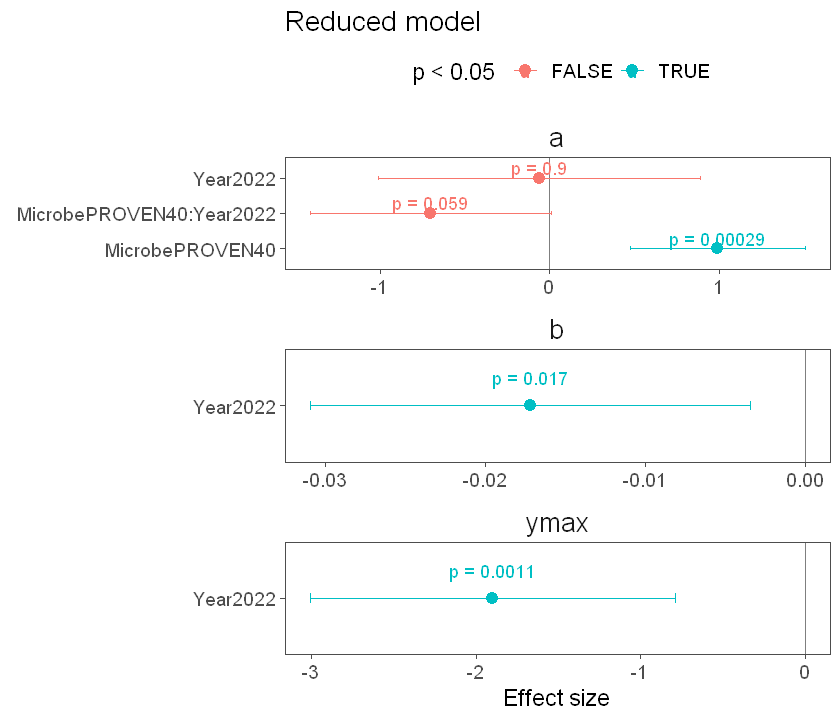

In [41]:
options(repr.plot.width=7, repr.plot.height=6)

fit.nlme.red_effects <- 
intervals(fit.nlme.red,level = 1 - alpha_level,which = "fixed")$fixed %>% 
as.data.frame() %>% 
mutate(term = row.names(.)) %>% 
bind_cols(fit.nlme.red.summary$tTable %>% data.frame()) %>% 
separate(term, c("param","term"), sep = "\\.") %>%
filter(!grepl("Int",term))# %>%

fit.nlme.red_effects 

fit.nlme.red_effects %>% 
ggplot(aes(est., term, colour = p.value < alpha_level)) +
geom_vline(xintercept = 0, colour = "gray50") + 
geom_errorbarh(aes(xmin = lower, xmax = upper), height = 0.1) + 
geom_point(size = 3) +
geom_text(aes(label = paste0("p = ", signif(p.value,2))),nudge_y = 0.3) + 
facet_wrap(~param,ncol = 1, scales = "free") + 
labs(y = "", x = "Effect size", title = "Reduced model", colour = paste0("p < ",alpha_level)) + 
theme(legend.position = "top")

Overall reading of these results:

- Strong evidence that `ymax` was higher in 2021 overall
- Convicing evidence that `Microbe` increased `a` across both years
- Marginal evidence that `Microbe` increased `a` less in 2022

## Plotting response curves

In order to get a range of the uncertanty regarding the estimated response curves, we perform a bootstrapping approach that resamples the residuals from the original model fit.

In [42]:
if(use_cached_boostrapping){

fit.nlme.red.boot_coeffs <- read.csv("datasets/reduced_model_boostrapped_coeffs_resid_2.csv")

} else {
  
  resid <- residuals(fit.nlme.red)

  fit.nlme.red.boot_coeffs <- data.frame(t(fixef(fit.nlme.red))) %>% mutate(n = 0)

  grps <- unique(df$grp)

  for(i in (1:n_boot_sims)){
      
    newdata <- df %>% mutate(yield = predict(fit.nlme.red) + sample(resid,size = length(resid),replace = TRUE))
    
    fit.nlme.red.boot <- try(
        update(fit.nlme.red,
              data = newdata,
              random = list(Year = pdDiag(a + b + ymax ~ 1), 
                            Rep = pdDiag(a + b + ymax~ 1)))
    )
      
      if(class(fit.nlme.red.boot)[1] != 'try-error'){
          
          fit.nlme.red.boot_coeffs <- data.frame(t(fixef(fit.nlme.red.boot))) %>% 
          mutate(n = i) %>% 
          bind_rows(fit.nlme.red.boot_coeffs)
      
      }

  }

  write_csv(fit.nlme.red.boot_coeffs,"datasets/reduced_model_boostrapped_coeffs_resid_2.csv")

}



Extract estimated parameters to calculate response curves.

In [43]:
fit.nlme.red.boot_yield <- fit.nlme.red.boot_coeffs %>% 
rowwise() %>% 
mutate(df = list(expand_grid(N_Rate_num = 0:(300*1.12),
            Year = unique(df$Year),
            Microbe = unique(df$Microbe)))) %>% 
unnest(df) %>%
ungroup() %>% 
mutate(a = a..Intercept. + (Microbe=="PROVEN40")*a.MicrobePROVEN40 + (Year==2022)*a.Year2022 + (Microbe=="PROVEN40")*(Year==2022)*a.MicrobePROVEN40.Year2022,
       b = b..Intercept. + (Year==2022)*b.Year2022,
       ymax = ymax..Intercept. + (Year==2022)*ymax.Year2022, 
       yield = yield_nresp(N_Rate_num,a,b,ymax))

head(fit.nlme.red.boot_yield)

a..Intercept.,a.MicrobePROVEN40,a.Year2022,a.MicrobePROVEN40.Year2022,b..Intercept.,b.Year2022,ymax..Intercept.,ymax.Year2022,n,N_Rate_num,Year,Microbe,a,b,ymax,yield
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
7.429443,1.118266,0.6699091,-0.9253089,0.07333455,-0.02055335,17.48868,-1.701607,300,0,2021,PROVEN40,8.547708,0.07333455,17.48868,8.547708
7.429443,1.118266,0.6699091,-0.9253089,0.07333455,-0.02055335,17.48868,-1.701607,300,0,2021,UTC,7.429443,0.07333455,17.48868,7.429443
7.429443,1.118266,0.6699091,-0.9253089,0.07333455,-0.02055335,17.48868,-1.701607,300,0,2022,PROVEN40,8.292309,0.05278120,15.78707,8.292309
7.429443,1.118266,0.6699091,-0.9253089,0.07333455,-0.02055335,17.48868,-1.701607,300,0,2022,UTC,8.099352,0.05278120,15.78707,8.099352
7.429443,1.118266,0.6699091,-0.9253089,0.07333455,-0.02055335,17.48868,-1.701607,300,1,2021,PROVEN40,8.547708,0.07333455,17.48868,8.620892
7.429443,1.118266,0.6699091,-0.9253089,0.07333455,-0.02055335,17.48868,-1.701607,300,1,2021,UTC,7.429443,0.07333455,17.48868,7.502644


Warning message in stat_summary(data = df, aes(N_Rate_num, yield, shape = Microbe, :
"Ignoring unknown aesthetics: shape and fill"


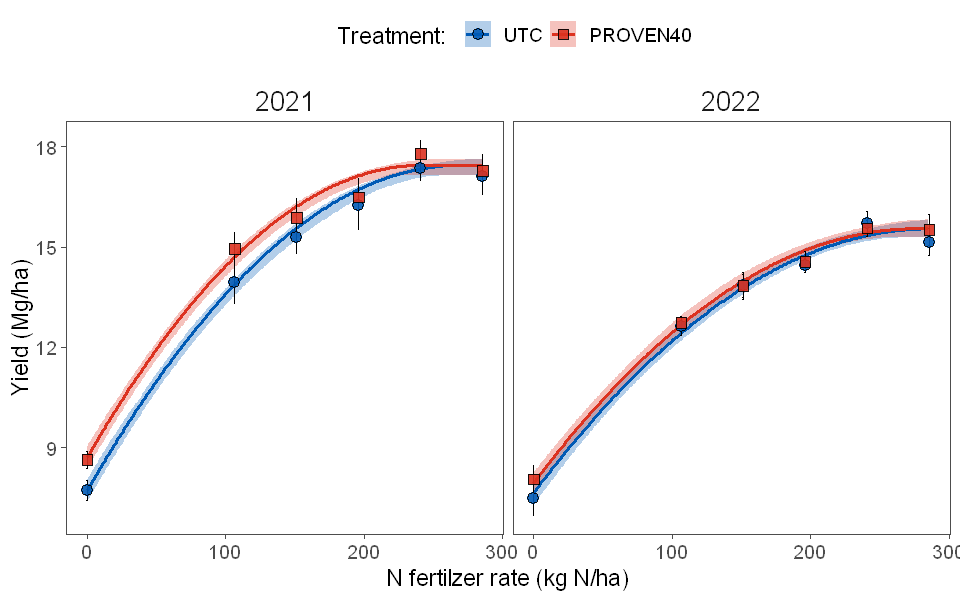

In [44]:
options(repr.plot.width=8, repr.plot.height=5)

ggplot() + 
stat_summary(data = fit.nlme.red.boot_yield %>% filter(N_Rate_num <= max(df$N_Rate_num)),
             aes(N_Rate_num,yield,fill = Microbe),
             geom = "ribbon",
             fun.min = function(x) quantile(x,alpha_level),
             fun.max = function(x) quantile(x,1 - alpha_level),
             alpha = 0.3) + 
geom_line(data = fit.nlme.red.boot_yield %>% filter(n == 0, N_Rate_num <= max(df$N_Rate_num)), 
          aes(N_Rate_num, yield, colour = Microbe),
          lwd = 1) + 
stat_summary(data = df,
             aes(N_Rate_num,yield,shape = Microbe, fill = Microbe),
             geom = "errorbar",
             fun.min = function(x) mean(x) - sd(x)/sqrt(length(x)),
             fun.max = function(x) mean(x) + sd(x)/sqrt(length(x)), width = 1) + 
stat_summary(data = df,
             aes(N_Rate_num,yield,shape = Microbe, fill = Microbe),
             geom = "point",fun = "mean", size = 3, alpha = 0.9, colour = "black") + 
facet_wrap(~Year) + 
scale_shape_manual(values = 21:22) + 
scale_fill_manual(values = myColorPalette) + 
scale_colour_manual(values = myColorPalette) + 
labs(y = "Yield (Mg/ha)", x = "N fertilzer rate (kg N/ha)", 
     colour = "Treatment:", shape = "Treatment:",
     fill = "Treatment:") + 
theme(legend.position = "top")

Another way of visualizing the response is by looking at the differences between the two lines.

`summarise()` has grouped output by 'N_Rate_num'. You can override using the
`.groups` argument.
Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


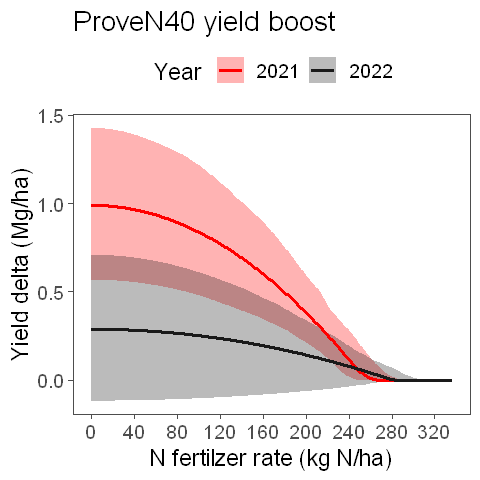

In [45]:
options(repr.plot.width=4, repr.plot.height=4)

fit.nlme.red.boot_yield %>%
dplyr::select(n:Microbe,yield) %>%
spread(Microbe,yield) %>% 
mutate(yield_delta = PROVEN40 - UTC) %>% 
group_by(N_Rate_num,Year) %>% 
summarise(upr = quantile(yield_delta,1 - alpha_level/2),
          lwr = quantile(yield_delta,alpha_level/2),
          yield_delta = sum(yield_delta*(n==0))) %>% 
ggplot(aes(N_Rate_num)) + 
geom_ribbon(aes(ymax = upr, ymin = lwr, fill = Year), alpha = 0.3) + 
geom_line(aes(y = yield_delta, colour  = Year), size = 1) +
scale_colour_manual(values = c("red","gray10")) + 
scale_fill_manual(values = c("red","gray10")) + 
#scale_y_continuous(breaks = 0:10*2) + 
scale_x_continuous(breaks = 0:8*40) + 
theme(legend.position = "top") + 
labs(title = "ProveN40 yield boost", y = "Yield delta (Mg/ha)", x = "N fertilzer rate (kg N/ha)")

## Calculate Agronomic Optimum N Rate (AONR) for both treatments and years

One way to estimate the AONR is by looking at the point where yield plateaus

In [46]:
yield_pred <- expand_grid(N_Rate_num = 0:3500/10,
            Year = unique(df$Year),
            Microbe = unique(df$Microbe)) %>%
mutate(yield_pred = predict(fit.nlme.red,level = 0, newdata = .))# %>% 

yield_pred %>% 
group_by(Year,Microbe) %>% 
filter(yield_pred == max(yield_pred)) %>% 
filter(N_Rate_num == min(N_Rate_num)) 

N_Rate_num,Year,Microbe,yield_pred
<dbl>,<fct>,<fct>,<dbl>
242.5,2021,PROVEN40,17.44761
269.9,2021,UTC,17.44761
276.8,2022,PROVEN40,15.54775
287.3,2022,UTC,15.54775


This can be done analitically via the following function:

In [47]:
aonr_nresp <- function(a,b,ymax){
    c = (-b**2)/(4*(ymax-a))
    aonr = -0.5 * b/c
    return(aonr)
    }

In [48]:
fit.nlme.red.boot_aonr <- fit.nlme.red.boot_yield %>% 
dplyr::select(n,Year:ymax) %>%
unique() %>%
mutate(aonr = aonr_nresp(a,b,ymax))

head(fit.nlme.red.boot_aonr)

n,Year,Microbe,a,b,ymax,aonr
<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
300,2021,PROVEN40,8.547708,0.07333455,17.48868,243.8405
300,2021,UTC,7.429443,0.07333455,17.48868,274.3382
300,2022,PROVEN40,8.292309,0.05278120,15.78707,283.9936
300,2022,UTC,8.099352,0.05278120,15.78707,291.3051
299,2021,PROVEN40,8.036277,0.07358727,17.26548,250.8370
299,2021,UTC,7.265147,0.07358727,17.26548,271.7953


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


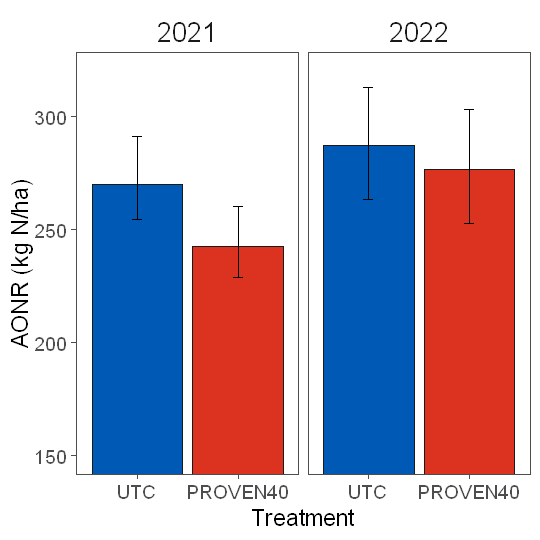

In [49]:
options(repr.plot.width=4.5, repr.plot.height=4.5)


fit.nlme.red.boot_aonr %>% 
ggplot(aes(Microbe,aonr,fill = Microbe, shape = Microbe)) +
geom_col(data = fit.nlme.red.boot_aonr %>% filter(n == 0), colour = "gray10") + 
stat_summary(geom = "errorbar",
             fun.min = function(x) quantile(x,alpha_level),
             fun.max = function(x) quantile(x,1 - alpha_level), width = 0.1) + 
facet_grid(~Year) +  
scale_fill_manual(values = c("gray70","gray30")) + 
scale_colour_manual(values = c("gray70","gray30")) + 
scale_shape_manual(values = 21:22) + 
scale_fill_manual(values = myColorPalette) + 
scale_colour_manual(values = myColorPalette) + 
labs(x = "Treatment", 
     y = "AONR (kg N/ha)") + 
coord_cartesian(ylim = c(150,320)) + 
theme(legend.position = "none")

In [50]:
fit.nlme.red.boot_aonr %>% 
dplyr::select(n:Microbe,aonr) %>%
group_by(Year,Microbe) %>%
summarise(upr = quantile(aonr,1 - alpha_level/2),
          lwr = quantile(aonr,alpha_level/2),
          pred = sum((n==0)*aonr))

`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.


Year,Microbe,upr,lwr,pred
<fct>,<fct>,<dbl>,<dbl>,<dbl>
2021,UTC,294.0870,251.8698,269.8551
2021,PROVEN40,263.1543,225.8986,242.4322
2022,UTC,317.0955,259.7313,287.2394
2022,PROVEN40,307.8214,247.8265,276.7118


In [51]:
fit.nlme.red.boot_aonr %>% 
dplyr::select(n:Microbe,aonr) %>%
spread(Microbe,aonr) %>% 
mutate(delta_aonr = PROVEN40 - UTC) %>% 
group_by(Year) %>%
summarise(upr = quantile(delta_aonr,1 - alpha_level/2),
          lwr = quantile(delta_aonr,alpha_level/2),
          pred = sum((n==0)*delta_aonr))

Year,upr,lwr,pred
<fct>,<dbl>,<dbl>,<dbl>
2021,-15.943702,-40.29947,-27.42286
2022,4.372451,-25.25764,-10.52760


`summarise()` has grouped output by 'Microbe'. You can override using the
`.groups` argument.
Warning message in geom_errorbarh(data = fit.nlme.red.boot_aonr %>% group_by(Microbe, :
"Ignoring unknown parameters: `width`"
Warning message in stat_summary(data = df, aes(N_Rate_num, yield, shape = Microbe, :
"Ignoring unknown aesthetics: shape and fill"


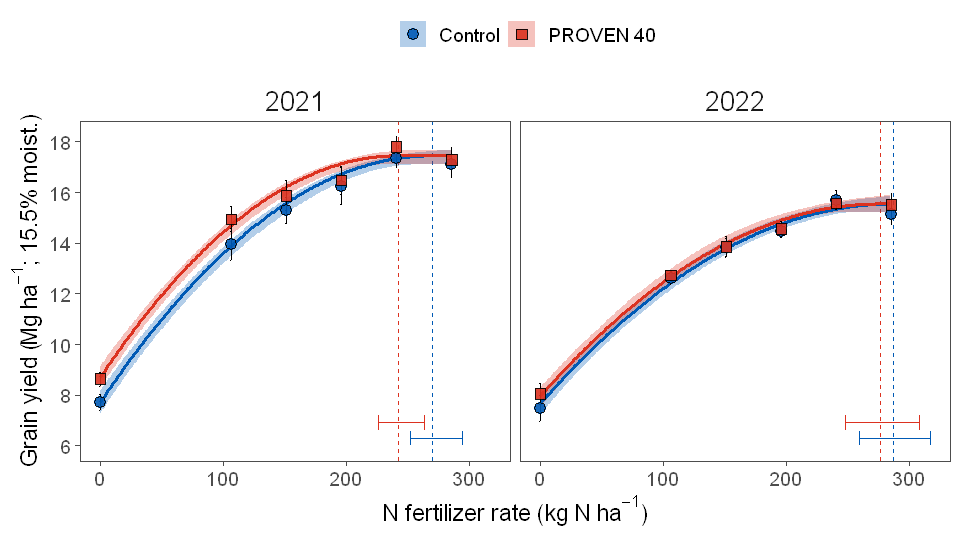

In [52]:
options(repr.plot.width=8, repr.plot.height=4.5)

pfinal1 <- ggplot() + 
geom_vline(data = fit.nlme.red.boot_aonr %>% filter(n == 0), aes(xintercept = aonr, colour = Microbe), linetype = 2) +          
stat_summary(data = fit.nlme.red.boot_yield %>% filter(N_Rate_num <= max(df$N_Rate_num)),
             aes(N_Rate_num,yield,fill = Microbe),
             geom = "ribbon",
             fun.min = function(x) quantile(x,alpha_level/2),
             fun.max = function(x) quantile(x,1 - alpha_level/2),
             alpha = 0.3) + 
geom_line(data = fit.nlme.red.boot_yield %>% filter(n == 0, N_Rate_num <= max(df$N_Rate_num)), 
          aes(N_Rate_num, yield, colour = Microbe),
          lwd = 1) + 
geom_errorbarh(data = fit.nlme.red.boot_aonr %>%
                      group_by(Microbe,Year) %>% 
                      summarise(upr =  quantile(aonr,alpha_level/2),
               lwr =  quantile(aonr,1 - alpha_level/2)), 
               aes(xmin = lwr, xmax = upr, y = ifelse(Microbe == "UTC",100*0.0628,110*0.0628), colour = Microbe), width = 0.1) + 
stat_summary(data = df,
             aes(N_Rate_num,yield,shape = Microbe, fill = Microbe),
             geom = "errorbar",
             fun.min = function(x) mean(x) - sd(x)/sqrt(length(x)),
             fun.max = function(x) mean(x) + sd(x)/sqrt(length(x)), width = 1) + 
stat_summary(data = df,
             aes(N_Rate_num,yield,shape = Microbe, fill = Microbe),
             geom = "point",fun = "mean", size = 3, alpha = 0.9, colour = "black") + 
facet_wrap(~Year) + 
scale_shape_manual(labels = c("Control", "PROVEN 40"), values = 21:22) + 
scale_fill_manual(labels = c("Control", "PROVEN 40"), values = myColorPalette) + 
scale_colour_manual(labels = c("Control", "PROVEN 40"), values = myColorPalette) + 
scale_y_continuous(breaks = 3:9*2) + 
labs(y = expression("Grain yield ("*Mg~ha^-1*"; 15.5% moist.)"), 
     x = expression("N fertilizer rate (kg N"~ha^-1*")"),
     colour = "", shape = "",
     fill = "") + 
guides(colour = "none") + 
theme(legend.position = "top")

pfinal1


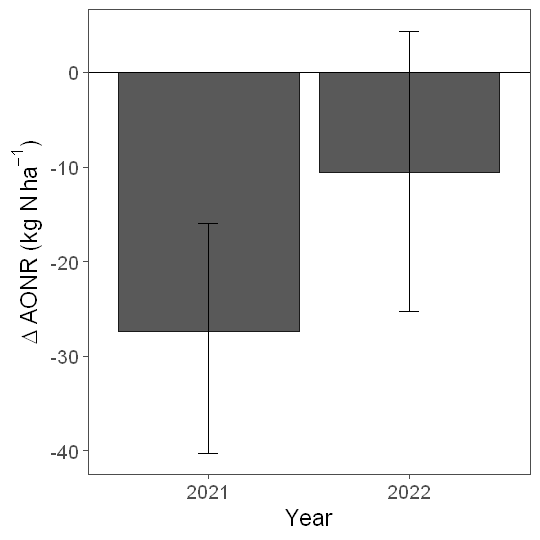

In [53]:
options(repr.plot.width=4.5, repr.plot.height=4.5)

pfinal2 <- fit.nlme.red.boot_aonr %>% 
dplyr::select(n:Microbe,aonr) %>%
spread(Microbe,aonr) %>% 
mutate(delta_aonr = PROVEN40 - UTC) %>%
ggplot(aes(Year,delta_aonr)) +
geom_col(data = fit.nlme.red.boot_aonr %>% 
         dplyr::select(n:Microbe,aonr) %>%
         filter(n == 0) %>% 
         spread(Microbe,aonr) %>% 
         mutate(delta_aonr = PROVEN40 - UTC), colour = "gray10") + 
stat_summary(geom = "errorbar",
             fun.min = function(x) quantile(x,alpha_level/2),
             fun.max = function(x) quantile(x,1 - alpha_level/2), width = 0.1) + 
#geom_point(shape = "-",alpha = 0.3, size = 4) + 
geom_hline(yintercept = 0) + 
scale_shape_manual(values = 21:22) + 
labs(x = "Year", 
     y = expression(Delta~AONR~"(kg N"~ha^-1*")")) + 
theme(legend.position = "none")

pfinal2

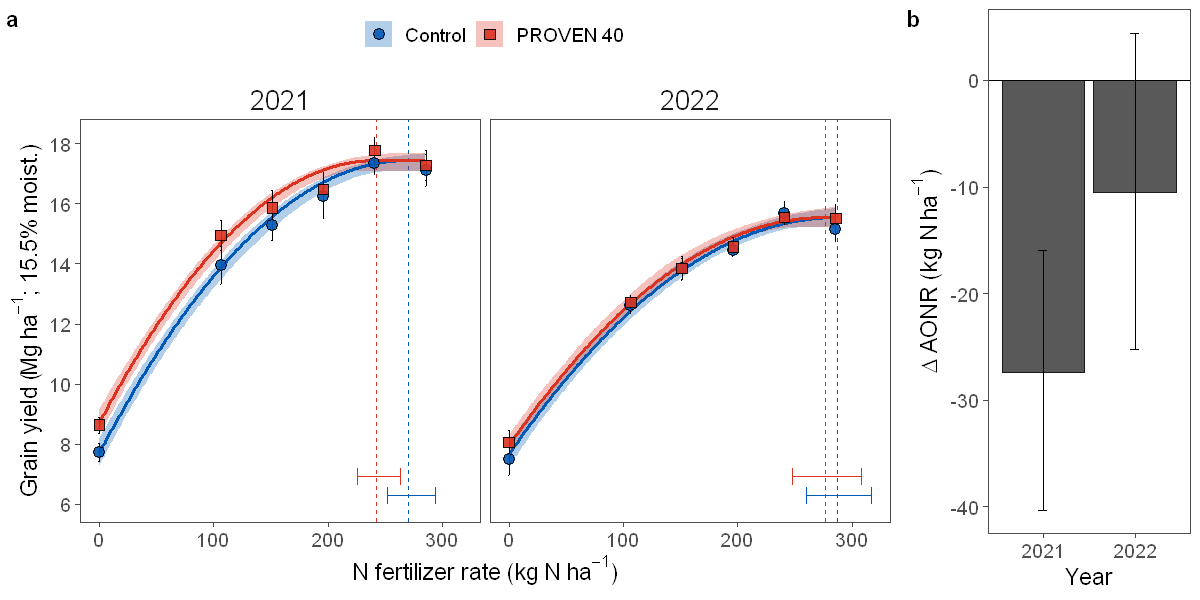

In [54]:
options(repr.plot.width=10, repr.plot.height=5)

ggarrange(pfinal1,pfinal2, widths = c(0.75,0.25),common.legend = FALSE, labels = c("a","b"))
ggsave("./figures/yield_response_and_aonr.jpeg",width = 10, height = 5, dpi = 300)
